# Predicting the number from looking at the handwritten image 




## 1. Problem Definition 

 
> The aim is to predict the number from looking at the handwritten image. 

>The dataset contains information about images, each image is a hand-written digit. The aim is to have >the computer predict which digit was written by the person, automatically, by "looking" at the image. 

>Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. >Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that >pixel.

>The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in >the 28 x 28 format). 

>The data set the has 785 columns. The first column, called "label", is the digit that was drawn by >the user. The rest of the columns contain the pixel-values of the associated image.

## 2. Data 

>Data is available on Kaggle https://www.kaggle.com/code/ngbolin/mnist-dataset-digit-recognizer




In [1]:
import itertools 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from functools import partial
import tensorflow as tf
import random as python_random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

In [2]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [3]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
from hyperopt import hp, tpe, fmin, Trials

## Load Data 

In [4]:
df = pd.read_csv('mnist.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Explolatory Data Analysis 

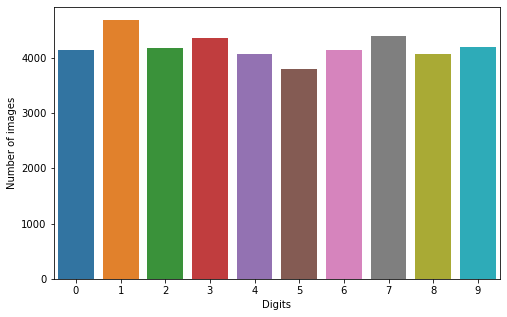

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(x='label',data=df)
plt.xlabel('Digits')
plt.ylabel('Number of images');

## Data Preprocessing 

In [6]:
# split data into train and test 
np.random.seed(42) # for reproducibilty 
X = df.drop('label',axis=1) # images 
y = df['label'] # target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [7]:
X_train.shape,X_test.shape

((37800, 784), (4200, 784))

#### Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

#### Reshape

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

#### Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([8, 5, 6, 2, 7, 1, 4, 0, 3, 9], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

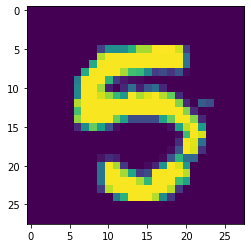

In [12]:
# Some image examples 

g = plt.imshow(X_train[1][:,:,0])

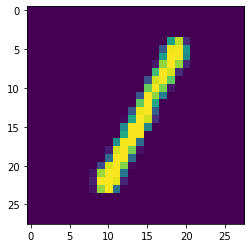

In [13]:
# Some image examples 

g = plt.imshow(X_train[7][:,:,0])

## Modeling 

In [14]:
# function to create the CNN

def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we will only optimize the activation function.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Hyperparameter Space Tuning 

In [15]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

In [16]:
# the hyperparameter space grid

param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

### Define the Objective Function

In [17]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [18]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

### Test run

In [19]:
# Before we run the hyper-parameter optimization, 
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = [1e-5, 1, 16, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 162s 407ms/step - loss: 2.2683 - accuracy: 0.1277 - val_loss: 2.2221 - val_accuracy: 0.2365 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 92s 346ms/step - loss: 2.1648 - accuracy: 0.3419 - val_loss: 2.0975 - val_accuracy: 0.4495 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 95s 359ms/step - loss: 2.0084 - accuracy: 0.4915 - val_loss: 1.9068 - val_accuracy: 0.5466 - lr: 1.0000e-05

Accuracy: 54.66%



-0.5465608239173889

### Bayesian Optimization

In [20]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
266/266 [==============================] - 135s 364ms/step - loss: 2.2742 - accuracy: 0.1643 - val_loss: 2.2326 - val_accuracy: 0.2198 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 93s 351ms/step - loss: 2.1669 - accuracy: 0.2790 - val_loss: 2.0862 - val_accuracy: 0.3294 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 84s 317ms/step - loss: 1.9710 - accuracy: 0.4003 - val_loss: 1.8538 - val_accuracy: 0.4537 - lr: 1.0000e-05

Accuracy: 45.37%

learning rate: 2.4e-04
num_dense_layers: 4
num_dense_nodes: 440
activation: sigmoid

Epoch 1/3
266/266 [==============================] - 153s 410ms/step - loss: 2.3131 - accuracy: 0.1013 - val_loss: 2.3087 - val_accuracy: 0.1130 - lr: 2.3517e-04
Epoch 2/3
266/266 [==============================] - 109s 411ms/step - loss: 1.8412 - accuracy: 0.3338 - val_loss: 0.9204 - val_accuracy: 0.6952 - lr: 2.3517e-04
Epoch 3

C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 116s 342ms/step - loss: 2.1500 - accuracy: 0.1849 - val_loss: 0.9798 - val_accuracy: 0.6603 - lr: 7.5654e-04
Epoch 2/3
266/266 [==============================] - 83s 314ms/step - loss: 0.5383 - accuracy: 0.8198 - val_loss: 0.3017 - val_accuracy: 0.9050 - lr: 7.5654e-04
Epoch 3/3
266/266 [==============================] - 85s 319ms/step - loss: 0.2609 - accuracy: 0.9158 - val_loss: 0.2068 - val_accuracy: 0.9315 - lr: 7.5654e-04

Accuracy: 93.15%

learning rate: 1.9e-04
num_dense_layers: 4
num_dense_nodes: 364
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 124s 329ms/step - loss: 0.5345 - accuracy: 0.8415 - val_loss: 0.1954 - val_accuracy: 0.9410 - lr: 1.8603e-04
Epoch 2/3
266/266 [==============================] - 84s 316ms/step - loss: 0.1343 - accuracy: 0.9585 - val_loss: 0.1143 - val_accuracy: 0.9656 - lr: 1.8603e-04
Epoch 3/3
266/266 [==============================] - 82s 307ms/step - loss: 0.0915 - accuracy: 0.9714 - val_loss: 0.0764 - val_accuracy: 0.9775 - lr: 1.8603e-04

Accuracy: 97.75%

learning rate: 6.5e-04
num_dense_layers: 5
num_dense_nodes: 337
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 114s 315ms/step - loss: 0.3399 - accuracy: 0.8909 - val_loss: 0.0972 - val_accuracy: 0.9688 - lr: 6.4773e-04
Epoch 2/3
266/266 [==============================] - 79s 298ms/step - loss: 0.0783 - accuracy: 0.9754 - val_loss: 0.0577 - val_accuracy: 0.9839 - lr: 6.4773e-04
Epoch 3/3
266/266 [==============================] - 80s 301ms/step - loss: 0.0509 - accuracy: 0.9845 - val_loss: 0.0462 - val_accuracy: 0.9857 - lr: 6.4773e-04

Accuracy: 98.57%

learning rate: 2.1e-03
num_dense_layers: 4
num_dense_nodes: 337
activation: sigmoid



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 115s 327ms/step - loss: 2.3256 - accuracy: 0.1008 - val_loss: 2.2333 - val_accuracy: 0.0955 - lr: 0.0021
Epoch 2/3
266/266 [==============================] - 87s 327ms/step - loss: 1.1882 - accuracy: 0.5335 - val_loss: 0.4402 - val_accuracy: 0.8664 - lr: 0.0021
Epoch 3/3
266/266 [==============================] - 87s 327ms/step - loss: 0.2912 - accuracy: 0.9117 - val_loss: 0.2144 - val_accuracy: 0.9378 - lr: 0.0021

Accuracy: 93.78%

learning rate: 1.2e-03
num_dense_layers: 2
num_dense_nodes: 354
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 108s 306ms/step - loss: 0.2340 - accuracy: 0.9273 - val_loss: 0.0741 - val_accuracy: 0.9788 - lr: 0.0012
Epoch 2/3
266/266 [==============================] - 84s 315ms/step - loss: 0.0606 - accuracy: 0.9806 - val_loss: 0.0553 - val_accuracy: 0.9852 - lr: 0.0012
Epoch 3/3
266/266 [==============================] - 77s 289ms/step - loss: 0.0403 - accuracy: 0.9868 - val_loss: 0.0422 - val_accuracy: 0.9873 - lr: 0.0012

Accuracy: 98.73%

learning rate: 2.4e-03
num_dense_layers: 1
num_dense_nodes: 152
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 104s 298ms/step - loss: 0.2052 - accuracy: 0.9352 - val_loss: 0.0658 - val_accuracy: 0.9780 - lr: 0.0024
Epoch 2/3
266/266 [==============================] - 73s 274ms/step - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.0492 - val_accuracy: 0.9852 - lr: 0.0024
Epoch 3/3
266/266 [==============================] - 77s 289ms/step - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.0445 - val_accuracy: 0.9870 - lr: 0.0024

Accuracy: 98.70%

learning rate: 1.6e-03
num_dense_layers: 3
num_dense_nodes: 284
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 108s 307ms/step - loss: 0.2435 - accuracy: 0.9230 - val_loss: 0.0946 - val_accuracy: 0.9693 - lr: 0.0016
Epoch 2/3
266/266 [==============================] - 77s 289ms/step - loss: 0.0597 - accuracy: 0.9816 - val_loss: 0.0600 - val_accuracy: 0.9815 - lr: 0.0016
Epoch 3/3
266/266 [==============================] - 95s 357ms/step - loss: 0.0424 - accuracy: 0.9871 - val_loss: 0.0505 - val_accuracy: 0.9836 - lr: 0.0016

Accuracy: 98.36%

learning rate: 1.3e-03
num_dense_layers: 2
num_dense_nodes: 321
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 129s 354ms/step - loss: 0.2276 - accuracy: 0.9303 - val_loss: 0.1041 - val_accuracy: 0.9706 - lr: 0.0013
Epoch 2/3
266/266 [==============================] - 84s 318ms/step - loss: 0.0618 - accuracy: 0.9809 - val_loss: 0.0548 - val_accuracy: 0.9847 - lr: 0.0013
Epoch 3/3
266/266 [==============================] - 90s 340ms/step - loss: 0.0416 - accuracy: 0.9869 - val_loss: 0.0443 - val_accuracy: 0.9870 - lr: 0.0013

Accuracy: 98.70%

learning rate: 1.3e-03
num_dense_layers: 2
num_dense_nodes: 304
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 117s 333ms/step - loss: 0.2353 - accuracy: 0.9279 - val_loss: 0.0763 - val_accuracy: 0.9767 - lr: 0.0013
Epoch 2/3
266/266 [==============================] - 91s 342ms/step - loss: 0.0577 - accuracy: 0.9821 - val_loss: 0.0536 - val_accuracy: 0.9812 - lr: 0.0013
Epoch 3/3
266/266 [==============================] - 99s 375ms/step - loss: 0.0389 - accuracy: 0.9872 - val_loss: 0.0461 - val_accuracy: 0.9862 - lr: 0.0013

Accuracy: 98.62%

learning rate: 1.4e-03
num_dense_layers: 2
num_dense_nodes: 283
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 119s 318ms/step - loss: 0.2212 - accuracy: 0.9305 - val_loss: 0.0797 - val_accuracy: 0.9743 - lr: 0.0014
Epoch 2/3
266/266 [==============================] - 78s 294ms/step - loss: 0.0570 - accuracy: 0.9823 - val_loss: 0.0557 - val_accuracy: 0.9844 - lr: 0.0014
Epoch 3/3
266/266 [==============================] - 89s 336ms/step - loss: 0.0387 - accuracy: 0.9875 - val_loss: 0.0547 - val_accuracy: 0.9841 - lr: 0.0014

Accuracy: 98.41%

learning rate: 3.1e-03
num_dense_layers: 2
num_dense_nodes: 102
activation: sigmoid



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 124s 353ms/step - loss: 2.3158 - accuracy: 0.1042 - val_loss: 2.3118 - val_accuracy: 0.0934 - lr: 0.0031
Epoch 2/3
266/266 [==============================] - 103s 387ms/step - loss: 2.3075 - accuracy: 0.1013 - val_loss: 2.3048 - val_accuracy: 0.1130 - lr: 0.0031
Epoch 3/3
266/266 [==============================] - 84s 317ms/step - loss: 2.3039 - accuracy: 0.1051 - val_loss: 2.3056 - val_accuracy: 0.0955 - lr: 0.0031

Accuracy: 9.55%

learning rate: 8.7e-04
num_dense_layers: 5
num_dense_nodes: 376
activation: sigmoid



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 144s 367ms/step - loss: 2.3156 - accuracy: 0.1066 - val_loss: 2.2333 - val_accuracy: 0.1733 - lr: 8.6869e-04
Epoch 2/3
266/266 [==============================] - 82s 310ms/step - loss: 1.0086 - accuracy: 0.6274 - val_loss: 0.5113 - val_accuracy: 0.8471 - lr: 8.6869e-04
Epoch 3/3
266/266 [==============================] - 93s 350ms/step - loss: 0.3900 - accuracy: 0.8835 - val_loss: 0.2748 - val_accuracy: 0.9246 - lr: 8.6869e-04

Accuracy: 92.46%

learning rate: 1.0e-02
num_dense_layers: 4
num_dense_nodes: 512
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 175s 494ms/step - loss: 2.3287 - accuracy: 0.1079 - val_loss: 2.3012 - val_accuracy: 0.1130 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 104s 392ms/step - loss: 2.3023 - accuracy: 0.1104 - val_loss: 2.3013 - val_accuracy: 0.1130 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1103
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
266/266 [==============================] - 101s 380ms/step - loss: 2.3020 - accuracy: 0.1103 - val_loss: 2.3020 - val_accuracy: 0.1130 - lr: 0.0100

Accuracy: 11.30%

learning rate: 1.0e-06
num_dense_layers: 4
num_dense_nodes: 320
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 128s 343ms/step - loss: 2.2992 - accuracy: 0.1202 - val_loss: 2.2915 - val_accuracy: 0.1714 - lr: 1.0000e-06
Epoch 2/3
266/266 [==============================] - 106s 399ms/step - loss: 2.2843 - accuracy: 0.2335 - val_loss: 2.2756 - val_accuracy: 0.2852 - lr: 1.0000e-06
Epoch 3/3
266/266 [==============================] - 81s 304ms/step - loss: 2.2663 - accuracy: 0.3437 - val_loss: 2.2555 - val_accuracy: 0.4140 - lr: 1.0000e-06

Accuracy: 41.40%

learning rate: 3.6e-03
num_dense_layers: 2
num_dense_nodes: 512
activation: sigmoid



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 117s 329ms/step - loss: 1.7577 - accuracy: 0.3523 - val_loss: 0.2510 - val_accuracy: 0.9280 - lr: 0.0036
Epoch 2/3
266/266 [==============================] - 91s 343ms/step - loss: 0.1520 - accuracy: 0.9524 - val_loss: 0.0842 - val_accuracy: 0.9728 - lr: 0.0036
Epoch 3/3
266/266 [==============================] - 91s 341ms/step - loss: 0.0705 - accuracy: 0.9779 - val_loss: 0.0646 - val_accuracy: 0.9804 - lr: 0.0036

Accuracy: 98.04%

learning rate: 1.1e-03
num_dense_layers: 5
num_dense_nodes: 5
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 129s 338ms/step - loss: 1.7105 - accuracy: 0.3273 - val_loss: 1.3469 - val_accuracy: 0.4624 - lr: 0.0011
Epoch 2/3
266/266 [==============================] - 75s 282ms/step - loss: 1.1866 - accuracy: 0.5269 - val_loss: 1.0661 - val_accuracy: 0.5616 - lr: 0.0011
Epoch 3/3
266/266 [==============================] - 75s 283ms/step - loss: 0.9314 - accuracy: 0.6178 - val_loss: 0.8446 - val_accuracy: 0.6532 - lr: 0.0011

Accuracy: 65.32%

learning rate: 5.2e-05
num_dense_layers: 2
num_dense_nodes: 244
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 102s 297ms/step - loss: 1.1949 - accuracy: 0.7488 - val_loss: 0.3885 - val_accuracy: 0.9037 - lr: 5.2150e-05
Epoch 2/3
266/266 [==============================] - 84s 317ms/step - loss: 0.2982 - accuracy: 0.9178 - val_loss: 0.2384 - val_accuracy: 0.9336 - lr: 5.2150e-05
Epoch 3/3
266/266 [==============================] - 80s 301ms/step - loss: 0.2134 - accuracy: 0.9374 - val_loss: 0.1930 - val_accuracy: 0.9474 - lr: 5.2150e-05

Accuracy: 94.74%

learning rate: 6.5e-05
num_dense_layers: 1
num_dense_nodes: 512
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 109s 321ms/step - loss: 0.9826 - accuracy: 0.7835 - val_loss: 0.3347 - val_accuracy: 0.9177 - lr: 6.4941e-05
Epoch 2/3
266/266 [==============================] - 86s 325ms/step - loss: 0.2708 - accuracy: 0.9228 - val_loss: 0.2180 - val_accuracy: 0.9434 - lr: 6.4941e-05
Epoch 3/3
266/266 [==============================] - 86s 322ms/step - loss: 0.1925 - accuracy: 0.9431 - val_loss: 0.1679 - val_accuracy: 0.9532 - lr: 6.4941e-05

Accuracy: 95.32%

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 164
activation: relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 101s 286ms/step - loss: 0.1878 - accuracy: 0.9437 - val_loss: 0.0705 - val_accuracy: 0.9794 - lr: 0.0100
Epoch 2/3
266/266 [==============================] - 80s 299ms/step - loss: 0.0584 - accuracy: 0.9815 - val_loss: 0.0461 - val_accuracy: 0.9868 - lr: 0.0100
Epoch 3/3
266/266 [==============================] - 72s 272ms/step - loss: 0.0483 - accuracy: 0.9857 - val_loss: 0.0528 - val_accuracy: 0.9862 - lr: 0.0100

Accuracy: 98.62%



### Analyze results

In [21]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9873'

In [22]:
gp_.x

[0.0012297074448392635, 2, 354, 'relu']

In [23]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=5, high=512, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

In [24]:
print("""Best parameters:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gp_.x[0], 
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Best parameters:
- learning rate=0.001230
- num_dense_layers=2
- num_nodes=354
- activation = relu


### Convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

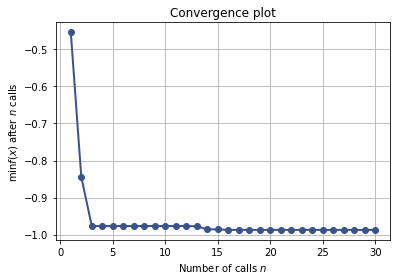

In [25]:
plot_convergence(gp_)

### Partially dependency plots


In [26]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

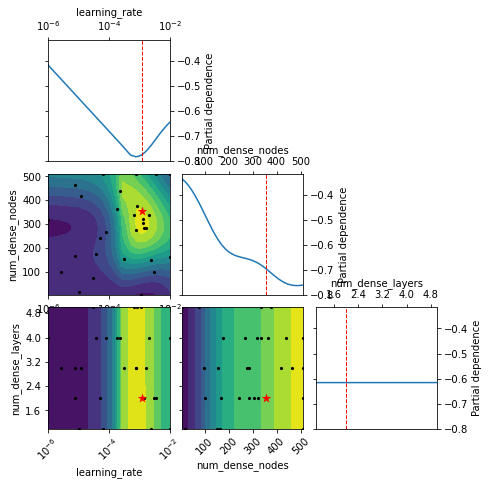

In [27]:
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

### Evaluation order


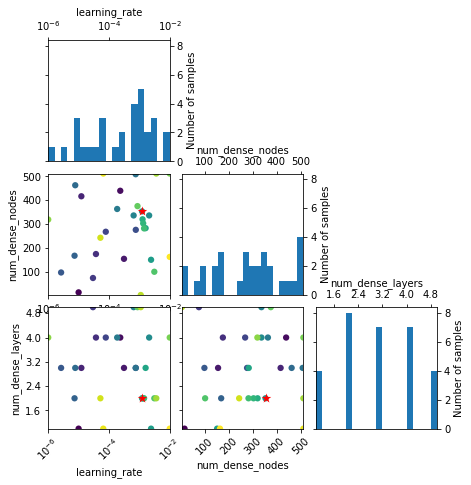

In [28]:
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

### Evaluate the model

In [29]:
# load best model

model = load_model(path_best_model)

In [30]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 28s 15ms/step - loss: 0.0473 - accuracy: 0.9864


In [31]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04733993485569954
accuracy 0.9864285588264465


#### Confusion matrix

In [32]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 [==============================] - 25s 12ms/step


array([[406,   0,   0,   1,   0,   0,   1,   0,   0,   0],
       [  0, 470,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   2, 413,   0,   2,   0,   0,   1,   2,   0],
       [  0,   1,   1, 498,   0,   1,   0,   2,   0,   3],
       [  0,   0,   0,   0, 390,   0,   3,   1,   0,   3],
       [  0,   0,   0,   3,   0, 332,   2,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0, 401,   0,   1,   0],
       [  0,   3,   3,   0,   1,   0,   0, 428,   1,   2],
       [  1,   2,   0,   1,   1,   2,   0,   1, 392,   3],
       [  0,   0,   0,   1,   0,   0,   0,   1,   1, 413]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

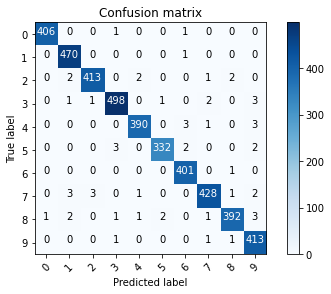

In [33]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


## TPE Hyperparameter Optimization of CNN - Hyperopt


In [34]:
# determine the hyperparameter space
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 1e-6, 1e-2),
    'num_conv_layers': hp.quniform('num_conv_layers', 1, 3, 1),
    'num_dense_layers': hp.quniform('num_dense_layers', 1, 5, 1),
    'num_dense_nodes': hp.quniform('num_dense_nodes', 5, 512, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
}

In [35]:
# function to create the CNN

def create_cnn(
    # the hyperparam to optimize are passed
    # as arguments
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function and
    # the number of convolutional layers that it can take.
    
    # We add the different number of conv layers in the following loop:
    
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [36]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [37]:
def objective(params):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.        
    print('learning rate: ', params['learning_rate'])
    print('num_conv_layers: ', int(params['num_conv_layers']))
    print('num_dense_layers: ',int(params['num_dense_layers']))
    print('num_dense_nodes: ', int(params['num_dense_nodes']))
    print('activation: ', params['activation'])
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=params['learning_rate'],
                       num_conv_layers=int(params['num_conv_layers']),
                       num_dense_layers=int(params['num_dense_layers']),
                       num_dense_nodes=int(params['num_dense_nodes']),
                       activation=params['activation'],
                       )

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

In [38]:
# Before we run the hyper-parameter optimization,
# let's first check that the everything is working
# by passing some default hyper-parameters.

default_parameters = {
    'learning_rate': 1e-5,
    'num_conv_layers': 1,
    'num_dense_layers': 1,
    'num_dense_nodes': 16,
    'activation': 'relu',
}


objective(default_parameters)

learning rate:  1e-05
num_conv_layers:  1
num_dense_layers:  1
num_dense_nodes:  16
activation:  relu



C:\Users\hi\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 112s 337ms/step - loss: 2.2628 - accuracy: 0.1475 - val_loss: 2.2092 - val_accuracy: 0.2571 - lr: 1.0000e-05
Epoch 2/3
266/266 [==============================] - 89s 335ms/step - loss: 2.1388 - accuracy: 0.3524 - val_loss: 2.0638 - val_accuracy: 0.4524 - lr: 1.0000e-05
Epoch 3/3
266/266 [==============================] - 73s 276ms/step - loss: 1.9636 - accuracy: 0.4961 - val_loss: 1.8654 - val_accuracy: 0.5661 - lr: 1.0000e-05

Accuracy: 56.61%



-0.5661375522613525

### Bayesian Optimization with TPE

In [39]:
# fmin performs the minimization
# tpe.suggest samples the parameters following tpe

# with default parameters for TPE
trials = Trials()

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest,  # tpe
    trials=trials
)

learning rate:                                        
0.006517772255089191                                  
num_conv_layers:                                      
3                                                     
num_dense_layers:                                     
3                                                     
num_dense_nodes:                                      
418                                                   
activation:                                           
relu                                                  
Epoch 1/3                                             

 87/266 [========>.....................] - ETA: 4:07 - loss: 2.3280 - accuracy: 0.1060


181/266 [===================>..........] - ETA: 1:56 - loss: 2.3146 - accuracy: 0.1070


266/266 [==============================] - 430s 2s/step - loss: 2.3105 - accuracy: 0.1088 - val_loss: 2.3017 - val_accuracy: 0.1130 - lr: 0.0065

Epoch 2/3                                             

  7/266 [..............................] - ETA: 5:49 - loss: 2.3008 - accuracy: 0.1161


101/266 [==========>...................] - ETA: 3:54 - loss: 2.3021 - accuracy: 0.1088


195/266 [====================>.........] - ETA: 1:41 - loss: 2.3020 - accuracy: 0.1095


266/266 [==============================] - 404s 2s/step - loss: 2.3020 - accuracy: 0.1103 - val_loss: 2.3010 - val_accuracy: 0.1130 - lr: 0.0065

Epoch 3/3                                             

 21/266 [=>............................] - ETA: 5:37 - loss: 2.3017 - accuracy: 0.1109


115/266 [===========>..................] - ETA: 3:26 - loss: 2.3020 - accuracy: 0.1086


209/266 [======================>.......] - ETA: 1:19 - loss: 2.3019 - accuracy: 0.1104


266/266 [==============================] - ETA: 0s - loss: 2.3019 - accuracy: 0.1113
                                                      
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0032588860485702753.

266/266 [==============================] - 400s 2s/step - loss: 2.3019 - accuracy: 0.1113 - val_loss: 2.3014 - val_accuracy: 0.1130 - lr: 0.0065

Accuracy: 11.30%                                      
learning rate:                                                                        
0.000600301954624924                                                                  
num_conv_layers:                                                                      
3                                                                                     
num_dense_layers:                                                                     
3                                                                                     
num_dense_nodes:                                            

116/266 [============>.................] - ETA: 3:30 - loss: 2.3127 - accuracy: 0.1047


210/266 [======================>.......] - ETA: 1:18 - loss: 2.3104 - accuracy: 0.1027


266/266 [==============================] - 434s 2s/step - loss: 2.3093 - accuracy: 0.1036 - val_loss: 2.3082 - val_accuracy: 0.1130 - lr: 6.0030e-04

Epoch 2/3                                                                             

 35/266 [==>...........................] - ETA: 6:30 - loss: 2.3061 - accuracy: 0.1018


129/266 [=============>................] - ETA: 3:48 - loss: 2.3063 - accuracy: 0.1051


223/266 [========================>.....] - ETA: 1:08 - loss: 2.3066 - accuracy: 0.1037


266/266 [==============================] - 438s 2s/step - loss: 2.3067 - accuracy: 0.1039 - val_loss: 2.3045 - val_accuracy: 0.1130 - lr: 6.0030e-04

Epoch 3/3                                                                             

 48/266 [====>.........................] - ETA: 5:25 - loss: 2.3090 - accuracy: 0.1011


142/266 [===============>..............] - ETA: 3:01 - loss: 2.3070 - accuracy: 0.1063


236/266 [=========================>....] - ETA: 43s - loss: 2.3075 - accuracy: 0.1052 


266/266 [==============================] - ETA: 0s - loss: 2.3074 - accuracy: 0.1044 
                                                                                      
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00030015097581781447.

266/266 [==============================] - 408s 2s/step - loss: 2.3074 - accuracy: 0.1044 - val_loss: 2.3062 - val_accuracy: 0.1087 - lr: 6.0030e-04

Accuracy: 10.87%                                                                      
learning rate:                                                                        
0.0015726398259184094                                                                 
num_conv_layers:                                                                      
2                                                                                     
num_dense_layers:                                                                     
1                                                                            

142/266 [===============>..............] - ETA: 1:56 - loss: 2.3186 - accuracy: 0.1038


236/266 [=========================>....] - ETA: 26s - loss: 2.3138 - accuracy: 0.1022 


266/266 [==============================] - 307s 996ms/step - loss: 2.3118 - accuracy: 0.1048 - val_loss: 2.2643 - val_accuracy: 0.1971 - lr: 0.0016

Epoch 2/3                                                                             

 61/266 [=====>........................] - ETA: 3:10 - loss: 1.6035 - accuracy: 0.5010


155/266 [================>.............] - ETA: 1:37 - loss: 0.9424 - accuracy: 0.7155


249/266 [===========================>..] - ETA: 14s - loss: 0.6833 - accuracy: 0.7946 


266/266 [==============================] - 250s 940ms/step - loss: 0.6522 - accuracy: 0.8041 - val_loss: 0.1917 - val_accuracy: 0.9505 - lr: 0.0016

Epoch 3/3                                                                             

 74/266 [=======>......................] - ETA: 2:34 - loss: 0.1679 - accuracy: 0.9518


168/266 [=================>............] - ETA: 1:18 - loss: 0.1562 - accuracy: 0.9549


262/266 [============================>.] - ETA: 3s - loss: 0.1422 - accuracy: 0.9582 


266/266 [==============================] - 243s 913ms/step - loss: 0.1414 - accuracy: 0.9584 - val_loss: 0.1099 - val_accuracy: 0.9693 - lr: 0.0016

Accuracy: 96.93%                                                                      
learning rate:                                                                        
0.007044895702734193                                                                 
num_conv_layers:                                                                     
2                                                                                    
num_dense_layers:                                                                    
2                                                                                    
num_dense_nodes:                                                                     
210                                                                                  
activation:                                                                

170/266 [==================>...........] - ETA: 1:28 - loss: 2.3315 - accuracy: 0.1052


264/266 [============================>.] - ETA: 1s - loss: 2.3245 - accuracy: 0.1034


266/266 [==============================] - 323s 1s/step - loss: 2.3244 - accuracy: 0.1033 - val_loss: 2.3035 - val_accuracy: 0.1087 - lr: 0.0070

Epoch 2/3                                                                              

 89/266 [=========>....................] - ETA: 2:29 - loss: 2.3083 - accuracy: 0.1022


183/266 [===================>..........] - ETA: 1:09 - loss: 2.3093 - accuracy: 0.0995


266/266 [==============================] - 252s 946ms/step - loss: 2.3094 - accuracy: 0.1010 - val_loss: 2.3056 - val_accuracy: 0.0934 - lr: 0.0070

Epoch 3/3                                                                              

  7/266 [..............................] - ETA: 3:19 - loss: 2.3034 - accuracy: 0.1172


101/266 [==========>...................] - ETA: 2:17 - loss: 2.3095 - accuracy: 0.1016


195/266 [====================>.........] - ETA: 1:02 - loss: 2.3090 - accuracy: 0.1021


266/266 [==============================] - ETA: 0s - loss: 2.3099 - accuracy: 0.1035  
                                                                                       
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035224477760493755.

266/266 [==============================] - 288s 1s/step - loss: 2.3099 - accuracy: 0.1035 - val_loss: 2.3111 - val_accuracy: 0.1087 - lr: 0.0070

Accuracy: 10.87%                                                                       
learning rate:                                                                         
0.003461839857747386                                                                   
num_conv_layers:                                                                       
2                                                                                      
num_dense_layers:                                                                      
1                                                                         

100/266 [==========>...................] - ETA: 2:11 - loss: 0.3793 - accuracy: 0.8827


194/266 [====================>.........] - ETA: 1:00 - loss: 0.2364 - accuracy: 0.9271


266/266 [==============================] - 50981s 192s/step - loss: 0.1920 - accuracy: 0.9409 - val_loss: 0.0551 - val_accuracy: 0.9836 - lr: 0.0035

Epoch 2/3                                                                               

 18/266 [=>............................] - ETA: 4:27 - loss: 0.0518 - accuracy: 0.9835 


111/266 [===========>..................] - ETA: 2:25 - loss: 0.0559 - accuracy: 0.9835 


204/266 [======================>.......] - ETA: 57s - loss: 0.0527 - accuracy: 0.9845   


266/266 [==============================] - 288s 1s/step - loss: 0.0508 - accuracy: 0.9851 - val_loss: 0.0436 - val_accuracy: 0.9876 - lr: 0.0035

Epoch 3/3                                                                               

 27/266 [==>...........................] - ETA: 4:03 - loss: 0.0316 - accuracy: 0.9896 


120/266 [============>.................] - ETA: 2:27 - loss: 0.0350 - accuracy: 0.9889 


213/266 [=======================>......] - ETA: 51s - loss: 0.0357 - accuracy: 0.9894   


266/266 [==============================] - 299s 1s/step - loss: 0.0377 - accuracy: 0.9885 - val_loss: 0.0474 - val_accuracy: 0.9862 - lr: 0.0035

Accuracy: 98.62%                                                                        
learning rate:                                                                             
0.007231756096517844                                                                       
num_conv_layers:                                                                           
2                                                                                          
num_dense_layers:                                                                          
2                                                                                          
num_dense_nodes:                                                                           
388                                                                                        
activation:                  

114/266 [===========>..................] - ETA: 2:09 - loss: 2.3102 - accuracy: 0.1074    


204/266 [======================>.......] - ETA: 58s - loss: 2.3066 - accuracy: 0.1068      


266/266 [==============================] - 399s 1s/step - loss: 2.3058 - accuracy: 0.1081 - val_loss: 2.3018 - val_accuracy: 0.1130 - lr: 0.0072

Epoch 2/3                                                                                  

 24/266 [=>............................] - ETA: 3:01 - loss: 2.3015 - accuracy: 0.1185    


114/266 [===========>..................] - ETA: 2:07 - loss: 2.3023 - accuracy: 0.1099    


203/266 [=====================>........] - ETA: 55s - loss: 2.3018 - accuracy: 0.1092      


266/266 [==============================] - 263s 989ms/step - loss: 2.3020 - accuracy: 0.1101 - val_loss: 2.3019 - val_accuracy: 0.1130 - lr: 0.0072

Epoch 3/3                                                                                  

 23/266 [=>............................] - ETA: 3:22 - loss: 2.3026 - accuracy: 0.1080    


113/266 [===========>..................] - ETA: 2:08 - loss: 2.3027 - accuracy: 0.1089    


202/266 [=====================>........] - ETA: 53s - loss: 2.3022 - accuracy: 0.1111      


266/266 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1113      
                                                                                           
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0036158780567348003.

266/266 [==============================] - 253s 954ms/step - loss: 2.3020 - accuracy: 0.1113 - val_loss: 2.3016 - val_accuracy: 0.1130 - lr: 0.0072

Accuracy: 11.30%                                                                           
learning rate:                                                                             
0.008693689806936774                                                                      
num_conv_layers:                                                                          
1                                                                                         
num_dense_layers:                                                                         
5                                          

100/266 [==========>...................] - ETA: 46s - loss: 2.4308 - accuracy: 0.1056     


190/266 [====================>.........] - ETA: 20s - loss: 2.3729 - accuracy: 0.1056     


266/266 [==============================] - 145s 389ms/step - loss: 2.3548 - accuracy: 0.1058 - val_loss: 2.3052 - val_accuracy: 0.0955 - lr: 0.0087

Epoch 2/3                                                                                 

 11/266 [>.............................] - ETA: 55s - loss: 2.3041 - accuracy: 0.1136     


101/266 [==========>...................] - ETA: 46s - loss: 2.3059 - accuracy: 0.1067     


191/266 [====================>.........] - ETA: 20s - loss: 2.3056 - accuracy: 0.1058     


266/266 [==============================] - 117s 441ms/step - loss: 2.3053 - accuracy: 0.1048 - val_loss: 2.3043 - val_accuracy: 0.1087 - lr: 0.0087

Epoch 3/3                                                                                 

 12/266 [>.............................] - ETA: 1:05 - loss: 2.3057 - accuracy: 0.0996   


102/266 [==========>...................] - ETA: 45s - loss: 2.3043 - accuracy: 0.1030     


192/266 [====================>.........] - ETA: 20s - loss: 2.3043 - accuracy: 0.1050     


266/266 [==============================] - 108s 405ms/step - loss: 2.3043 - accuracy: 0.1043 - val_loss: 2.3035 - val_accuracy: 0.1011 - lr: 0.0087

Accuracy: 10.11%                                                                          
learning rate:                                                                            
0.003370460412711838                                                                     
num_conv_layers:                                                                         
2                                                                                        
num_dense_layers:                                                                        
4                                                                                        
num_dense_nodes:                                                                         
38                                                                                       
activation:                            

 94/266 [=========>....................] - ETA: 2:26 - loss: 0.7990 - accuracy: 0.7247  


186/266 [===================>..........] - ETA: 1:07 - loss: 0.4701 - accuracy: 0.8410  


266/266 [==============================] - 291s 995ms/step - loss: 0.3586 - accuracy: 0.8801 - val_loss: 0.0789 - val_accuracy: 0.9765 - lr: 0.0034

Epoch 2/3                                                                                

  8/266 [..............................] - ETA: 3:34 - loss: 0.1191 - accuracy: 0.9736  


100/266 [==========>...................] - ETA: 2:11 - loss: 0.0841 - accuracy: 0.9756  


192/266 [====================>.........] - ETA: 58s - loss: 0.0740 - accuracy: 0.9782    


266/266 [==============================] - 238s 894ms/step - loss: 0.0726 - accuracy: 0.9787 - val_loss: 0.0583 - val_accuracy: 0.9833 - lr: 0.0034

Epoch 3/3                                                                                

 14/266 [>.............................] - ETA: 3:14 - loss: 0.0461 - accuracy: 0.9883  


106/266 [==========>...................] - ETA: 2:03 - loss: 0.0502 - accuracy: 0.9856  


197/266 [=====================>........] - ETA: 53s - loss: 0.0494 - accuracy: 0.9856    


266/266 [==============================] - 239s 899ms/step - loss: 0.0483 - accuracy: 0.9859 - val_loss: 0.0544 - val_accuracy: 0.9847 - lr: 0.0034

Accuracy: 98.47%                                                                         
learning rate:                                                                           
0.005735036233205236                                                                     
num_conv_layers:                                                                         
1                                                                                        
num_dense_layers:                                                                        
4                                                                                        
num_dense_nodes:                                                                         
372                                                                                      
activation:                              

 99/266 [==========>...................] - ETA: 39s - loss: 2.4132 - accuracy: 0.0960    


190/266 [====================>.........] - ETA: 18s - loss: 2.3654 - accuracy: 0.0993    


266/266 [==============================] - 126s 359ms/step - loss: 2.3480 - accuracy: 0.0992 - val_loss: 2.3048 - val_accuracy: 0.1130 - lr: 0.0057

Epoch 2/3                                                                                

 12/266 [>.............................] - ETA: 55s - loss: 2.3030 - accuracy: 0.1217    


103/266 [==========>...................] - ETA: 39s - loss: 2.3032 - accuracy: 0.1068    


194/266 [====================>.........] - ETA: 17s - loss: 2.3028 - accuracy: 0.1084    


266/266 [==============================] - 90s 340ms/step - loss: 2.3028 - accuracy: 0.1082 - val_loss: 2.3018 - val_accuracy: 0.1130 - lr: 0.0057

Epoch 3/3                                                                                

 16/266 [>.............................] - ETA: 53s - loss: 2.3012 - accuracy: 0.1084    


107/266 [===========>..................] - ETA: 37s - loss: 2.3013 - accuracy: 0.1032    


198/266 [=====================>........] - ETA: 16s - loss: 2.3016 - accuracy: 0.1077    


266/266 [==============================] - ETA: 0s - loss: 2.3018 - accuracy: 0.1083    
                                                                                         
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.002867518225684762.

266/266 [==============================] - 92s 348ms/step - loss: 2.3018 - accuracy: 0.1083 - val_loss: 2.3017 - val_accuracy: 0.1130 - lr: 0.0057

Accuracy: 11.30%                                                                         
learning rate:                                                                           
0.0070416364350044                                                                       
num_conv_layers:                                                                         
2                                                                                        
num_dense_layers:                                                                        
3                                                        

100/266 [==========>...................] - ETA: 2:11 - loss: 2.3066 - accuracy: 0.1060  


192/266 [====================>.........] - ETA: 58s - loss: 2.3041 - accuracy: 0.1091    


266/266 [==============================] - 262s 894ms/step - loss: 2.3036 - accuracy: 0.1101 - val_loss: 2.3013 - val_accuracy: 0.1130 - lr: 0.0070

Epoch 2/3                                                                                

 14/266 [>.............................] - ETA: 3:22 - loss: 2.3011 - accuracy: 0.1116  


106/266 [==========>...................] - ETA: 2:10 - loss: 2.3023 - accuracy: 0.1098  


197/266 [=====================>........] - ETA: 55s - loss: 2.3016 - accuracy: 0.1116    


266/266 [==============================] - 233s 876ms/step - loss: 2.3020 - accuracy: 0.1113 - val_loss: 2.3016 - val_accuracy: 0.1130 - lr: 0.0070

Epoch 3/3                                                                                

 19/266 [=>............................] - ETA: 3:17 - loss: 2.3019 - accuracy: 0.1098  


111/266 [===========>..................] - ETA: 2:06 - loss: 2.3017 - accuracy: 0.1123  


202/266 [=====================>........] - ETA: 52s - loss: 2.3019 - accuracy: 0.1113    


266/266 [==============================] - ETA: 0s - loss: 2.3019 - accuracy: 0.1113    
                                                                                         
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.003520818194374442.

266/266 [==============================] - 242s 909ms/step - loss: 2.3019 - accuracy: 0.1113 - val_loss: 2.3012 - val_accuracy: 0.1130 - lr: 0.0070

Accuracy: 11.30%                                                                         
learning rate:                                                                            
0.00954784968644422                                                                       
num_conv_layers:                                                                          
2                                                                                         
num_dense_layers:                                                                         
1                                                  

102/266 [==========>...................] - ETA: 2:20 - loss: 2.3139 - accuracy: 0.1101   


193/266 [====================>.........] - ETA: 1:03 - loss: 2.3098 - accuracy: 0.1084   


266/266 [==============================] - 294s 999ms/step - loss: 2.3087 - accuracy: 0.1059 - val_loss: 2.3071 - val_accuracy: 0.0955 - lr: 0.0095

Epoch 2/3                                                                                 

 14/266 [>.............................] - ETA: 4:49 - loss: 2.3087 - accuracy: 0.0921   


105/266 [==========>...................] - ETA: 2:42 - loss: 2.3044 - accuracy: 0.1032   


196/266 [=====================>........] - ETA: 1:14 - loss: 2.3048 - accuracy: 0.1016   


266/266 [==============================] - 302s 1s/step - loss: 2.3052 - accuracy: 0.1026 - val_loss: 2.3084 - val_accuracy: 0.1130 - lr: 0.0095

Epoch 3/3                                                                                 

 17/266 [>.............................] - ETA: 4:01 - loss: 2.3065 - accuracy: 0.1144   


108/266 [===========>..................] - ETA: 2:13 - loss: 2.3060 - accuracy: 0.1026   


198/266 [=====================>........] - ETA: 56s - loss: 2.3058 - accuracy: 0.1036     


266/266 [==============================] - 244s 918ms/step - loss: 2.3057 - accuracy: 0.1022 - val_loss: 2.3070 - val_accuracy: 0.1087 - lr: 0.0095

Accuracy: 10.87%                                                                          
learning rate:                                                                            
0.0030787381843904887                                                                     
num_conv_layers:                                                                          
1                                                                                         
num_dense_layers:                                                                         
3                                                                                         
num_dense_nodes:                                                                          
401                                                                                       
activation:                     

 98/266 [==========>...................] - ETA: 39s - loss: 0.4062 - accuracy: 0.8658     


188/266 [====================>.........] - ETA: 18s - loss: 0.2609 - accuracy: 0.9154     


266/266 [==============================] - 120s 344ms/step - loss: 0.2065 - accuracy: 0.9339 - val_loss: 0.1049 - val_accuracy: 0.9690 - lr: 0.0031

Epoch 2/3                                                                                 

  9/266 [>.............................] - ETA: 55s - loss: 0.0755 - accuracy: 0.9783     


 99/266 [==========>...................] - ETA: 38s - loss: 0.0618 - accuracy: 0.9803     


189/266 [====================>.........] - ETA: 18s - loss: 0.0572 - accuracy: 0.9818     


266/266 [==============================] - 98s 371ms/step - loss: 0.0591 - accuracy: 0.9819 - val_loss: 0.0568 - val_accuracy: 0.9825 - lr: 0.0031

Epoch 3/3                                                                                 

 10/266 [>.............................] - ETA: 52s - loss: 0.0418 - accuracy: 0.9883     


100/266 [==========>...................] - ETA: 38s - loss: 0.0483 - accuracy: 0.9856     


190/266 [====================>.........] - ETA: 18s - loss: 0.0450 - accuracy: 0.9868     


266/266 [==============================] - 85s 318ms/step - loss: 0.0462 - accuracy: 0.9865 - val_loss: 0.0666 - val_accuracy: 0.9841 - lr: 0.0031

Accuracy: 98.41%                                                                          
learning rate:                                                                            
0.0021694798888948863                                                                    
num_conv_layers:                                                                         
2                                                                                        
num_dense_layers:                                                                        
4                                                                                        
num_dense_nodes:                                                                         
149                                                                                      
activation:                             

 92/266 [=========>....................] - ETA: 2:22 - loss: 2.3260 - accuracy: 0.0973  


184/266 [===================>..........] - ETA: 1:06 - loss: 2.3188 - accuracy: 0.0990  


266/266 [==============================] - 307s 937ms/step - loss: 2.3166 - accuracy: 0.1009 - val_loss: 2.3285 - val_accuracy: 0.1130 - lr: 0.0022

Epoch 2/3                                                                                

  6/266 [..............................] - ETA: 3:28 - loss: 2.3237 - accuracy: 0.0964  


 98/266 [==========>...................] - ETA: 2:17 - loss: 2.3117 - accuracy: 0.1015  


190/266 [====================>.........] - ETA: 1:04 - loss: 2.3104 - accuracy: 0.1045  


266/266 [==============================] - 256s 965ms/step - loss: 2.3104 - accuracy: 0.1056 - val_loss: 2.3068 - val_accuracy: 0.0955 - lr: 0.0022

Epoch 3/3                                                                                

 12/266 [>.............................] - ETA: 3:26 - loss: 2.3095 - accuracy: 0.1022  


104/266 [==========>...................] - ETA: 2:09 - loss: 2.3107 - accuracy: 0.1055  


196/266 [=====================>........] - ETA: 1:02 - loss: 2.3092 - accuracy: 0.1049  


266/266 [==============================] - ETA: 0s - loss: 2.3086 - accuracy: 0.1040    
                                                                                         
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0010847399244084954.

266/266 [==============================] - 255s 960ms/step - loss: 2.3086 - accuracy: 0.1040 - val_loss: 2.3095 - val_accuracy: 0.1130 - lr: 0.0022

Accuracy: 11.30%                                                                         
learning rate:                                                                           
0.008821116007170426                                                                     
num_conv_layers:                                                                         
1                                                                                        
num_dense_layers:                                                                        
3                                                      

 96/266 [=========>....................] - ETA: 34s - loss: 2.3202 - accuracy: 0.1025    


187/266 [====================>.........] - ETA: 16s - loss: 2.3130 - accuracy: 0.1043    


266/266 [==============================] - 115s 311ms/step - loss: 2.3104 - accuracy: 0.1045 - val_loss: 2.3021 - val_accuracy: 0.0955 - lr: 0.0088

Epoch 2/3                                                                                

  9/266 [>.............................] - ETA: 48s - loss: 2.3000 - accuracy: 0.1085    


100/266 [==========>...................] - ETA: 33s - loss: 2.3024 - accuracy: 0.1064    


191/266 [====================>.........] - ETA: 15s - loss: 2.3027 - accuracy: 0.1058    


266/266 [==============================] - 78s 293ms/step - loss: 2.3024 - accuracy: 0.1068 - val_loss: 2.3023 - val_accuracy: 0.1130 - lr: 0.0088

Epoch 3/3                                                                                

 13/266 [>.............................] - ETA: 53s - loss: 2.3028 - accuracy: 0.1010    


104/266 [==========>...................] - ETA: 32s - loss: 2.3021 - accuracy: 0.1058    


195/266 [====================>.........] - ETA: 14s - loss: 2.3022 - accuracy: 0.1090    


266/266 [==============================] - 89s 335ms/step - loss: 2.3023 - accuracy: 0.1094 - val_loss: 2.3016 - val_accuracy: 0.1130 - lr: 0.0088

Accuracy: 11.30%                                                                         
learning rate:                                                                           
0.009739505518517877                                                                     
num_conv_layers:                                                                         
1                                                                                        
num_dense_layers:                                                                        
5                                                                                        
num_dense_nodes:                                                                         
123                                                                                      
activation:                               

 97/266 [=========>....................] - ETA: 36s - loss: 2.3408 - accuracy: 0.1041    


188/266 [====================>.........] - ETA: 17s - loss: 2.3233 - accuracy: 0.1051    


266/266 [==============================] - 114s 329ms/step - loss: 2.3174 - accuracy: 0.1066 - val_loss: 2.3023 - val_accuracy: 0.1130 - lr: 0.0097

Epoch 2/3                                                                                

 10/266 [>.............................] - ETA: 56s - loss: 2.3017 - accuracy: 0.1133    


101/266 [==========>...................] - ETA: 36s - loss: 2.3028 - accuracy: 0.1053    


192/266 [====================>.........] - ETA: 16s - loss: 2.3023 - accuracy: 0.1081    


266/266 [==============================] - 79s 298ms/step - loss: 2.3024 - accuracy: 0.1089 - val_loss: 2.3027 - val_accuracy: 0.1130 - lr: 0.0097

Epoch 3/3                                                                                

 14/266 [>.............................] - ETA: 56s - loss: 2.3027 - accuracy: 0.1177    


105/266 [==========>...................] - ETA: 35s - loss: 2.3024 - accuracy: 0.1101    


196/266 [=====================>........] - ETA: 15s - loss: 2.3023 - accuracy: 0.1098    


266/266 [==============================] - ETA: 0s - loss: 2.3023 - accuracy: 0.1103    
                                                                                         
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004869752563536167.

266/266 [==============================] - 87s 329ms/step - loss: 2.3023 - accuracy: 0.1103 - val_loss: 2.3015 - val_accuracy: 0.1130 - lr: 0.0097

Accuracy: 11.30%                                                                         
learning rate:                                                                           
0.003349266083786422                                                                    
num_conv_layers:                                                                        
1                                                                                       
num_dense_layers:                                                                       
5                                                            

 98/266 [==========>...................] - ETA: 39s - loss: 0.6320 - accuracy: 0.7903   


190/266 [====================>.........] - ETA: 18s - loss: 0.3887 - accuracy: 0.8747   


266/266 [==============================] - 123s 363ms/step - loss: 0.3088 - accuracy: 0.9024 - val_loss: 0.0840 - val_accuracy: 0.9762 - lr: 0.0033

Epoch 2/3                                                                               

 13/266 [>.............................] - ETA: 1:03 - loss: 0.0811 - accuracy: 0.9778 


105/266 [==========>...................] - ETA: 38s - loss: 0.0802 - accuracy: 0.9783   


197/266 [=====================>........] - ETA: 16s - loss: 0.0819 - accuracy: 0.9781   


266/266 [==============================] - 89s 336ms/step - loss: 0.0806 - accuracy: 0.9792 - val_loss: 0.0845 - val_accuracy: 0.9799 - lr: 0.0033

Epoch 3/3                                                                               

 20/266 [=>............................] - ETA: 59s - loss: 0.0516 - accuracy: 0.9867   


112/266 [===========>..................] - ETA: 38s - loss: 0.0599 - accuracy: 0.9855   


204/266 [======================>.......] - ETA: 16s - loss: 0.0611 - accuracy: 0.9849   


266/266 [==============================] - 106s 399ms/step - loss: 0.0606 - accuracy: 0.9853 - val_loss: 0.0737 - val_accuracy: 0.9820 - lr: 0.0033

Accuracy: 98.20%                                                                        
learning rate:                                                                          
0.004516805332775103                                                                    
num_conv_layers:                                                                        
3                                                                                       
num_dense_layers:                                                                       
4                                                                                       
num_dense_nodes:                                                                        
452                                                                                     
activation:                                       

109/266 [===========>..................] - ETA: 3:48 - loss: 2.3030 - accuracy: 0.1099 


202/266 [=====================>........] - ETA: 1:30 - loss: 2.3025 - accuracy: 0.1096 


266/266 [==============================] - 446s 2s/step - loss: 2.3023 - accuracy: 0.1095 - val_loss: 2.3018 - val_accuracy: 0.1130 - lr: 0.0045

Epoch 2/3                                                                               

 25/266 [=>............................] - ETA: 5:47 - loss: 2.3003 - accuracy: 0.1166 


118/266 [============>.................] - ETA: 3:40 - loss: 2.3019 - accuracy: 0.1125 


211/266 [======================>.......] - ETA: 1:19 - loss: 2.3018 - accuracy: 0.1118 


266/266 [==============================] - 409s 2s/step - loss: 2.3019 - accuracy: 0.1113 - val_loss: 2.3020 - val_accuracy: 0.1130 - lr: 0.0045

Epoch 3/3                                                                               

 34/266 [==>...........................] - ETA: 5:27 - loss: 2.3011 - accuracy: 0.1156 


127/266 [=============>................] - ETA: 3:14 - loss: 2.3014 - accuracy: 0.1147 


220/266 [=======================>......] - ETA: 1:04 - loss: 2.3016 - accuracy: 0.1106 


266/266 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.1095   
                                                                                        
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0022584027610719204.

266/266 [==============================] - 400s 2s/step - loss: 2.3017 - accuracy: 0.1095 - val_loss: 2.3015 - val_accuracy: 0.1130 - lr: 0.0045

Accuracy: 11.30%                                                                        
learning rate:                                                                          
0.009765276516317688                                                                    
num_conv_layers:                                                                        
2                                                                                       
num_dense_layers:                                                                       
1                                                                 

123/266 [============>.................] - ETA: 2:05 - loss: 2.3957 - accuracy: 0.1045 


215/266 [=======================>......] - ETA: 45s - loss: 2.3675 - accuracy: 0.1022   


266/266 [==============================] - 319s 1s/step - loss: 2.3635 - accuracy: 0.1014 - val_loss: 2.3780 - val_accuracy: 0.1011 - lr: 0.0098

Epoch 2/3                                                                               

 38/266 [===>..........................] - ETA: 3:47 - loss: 2.3476 - accuracy: 0.1038 


131/266 [=============>................] - ETA: 2:21 - loss: 2.3404 - accuracy: 0.1008 


223/266 [========================>.....] - ETA: 41s - loss: 2.3368 - accuracy: 0.1011   


266/266 [==============================] - 284s 1s/step - loss: 2.3366 - accuracy: 0.1010 - val_loss: 2.3578 - val_accuracy: 0.1130 - lr: 0.0098

Epoch 3/3                                                                               

 47/266 [====>.........................] - ETA: 2:51 - loss: 2.3362 - accuracy: 0.1034 


140/266 [==============>...............] - ETA: 1:38 - loss: 2.3362 - accuracy: 0.1085 


232/266 [=========================>....] - ETA: 26s - loss: 2.3378 - accuracy: 0.1054   


266/266 [==============================] - 233s 877ms/step - loss: 2.3390 - accuracy: 0.1052 - val_loss: 2.3407 - val_accuracy: 0.1016 - lr: 0.0098

Accuracy: 10.16%                                                                        
learning rate:                                                                          
0.004172209719165551                                                                    
num_conv_layers:                                                                        
1                                                                                       
num_dense_layers:                                                                       
4                                                                                       
num_dense_nodes:                                                                        
129                                                                                     
activation:                                       

136/266 [==============>...............] - ETA: 31s - loss: 2.3226 - accuracy: 0.1054   


228/266 [========================>.....] - ETA: 9s - loss: 2.3197 - accuracy: 0.1014   


266/266 [==============================] - 134s 371ms/step - loss: 2.3194 - accuracy: 0.1016 - val_loss: 2.3147 - val_accuracy: 0.1130 - lr: 0.0042

Epoch 2/3                                                                               

 51/266 [====>.........................] - ETA: 55s - loss: 2.3133 - accuracy: 0.0957   


143/266 [===============>..............] - ETA: 28s - loss: 2.3108 - accuracy: 0.0998   


235/266 [=========================>....] - ETA: 7s - loss: 2.3079 - accuracy: 0.1008   


266/266 [==============================] - 88s 331ms/step - loss: 2.3073 - accuracy: 0.1023 - val_loss: 2.3030 - val_accuracy: 0.1130 - lr: 0.0042

Epoch 3/3                                                                               

 58/266 [=====>........................] - ETA: 46s - loss: 2.3028 - accuracy: 0.1017   


150/266 [===============>..............] - ETA: 26s - loss: 2.3023 - accuracy: 0.1077   


242/266 [==========================>...] - ETA: 5s - loss: 2.3020 - accuracy: 0.1096   


266/266 [==============================] - ETA: 0s - loss: 2.3021 - accuracy: 0.1091   
                                                                                        
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0020861048251390457.

266/266 [==============================] - 90s 339ms/step - loss: 2.3021 - accuracy: 0.1091 - val_loss: 2.3020 - val_accuracy: 0.1130 - lr: 0.0042

Accuracy: 11.30%                                                                        
learning rate:                                                                          
0.0022991281242940253                                                                   
num_conv_layers:                                                                        
3                                                                                       
num_dense_layers:                                                                       
4                                                               

146/266 [===============>..............] - ETA: 2:39 - loss: 0.5132 - accuracy: 0.8196 


238/266 [=========================>....] - ETA: 37s - loss: 0.3593 - accuracy: 0.8773   


266/266 [==============================] - 413s 1s/step - loss: 0.3311 - accuracy: 0.8875 - val_loss: 0.0995 - val_accuracy: 0.9717 - lr: 0.0023

Epoch 2/3                                                                               

 62/266 [=====>........................] - ETA: 4:28 - loss: 0.0842 - accuracy: 0.9753 


155/266 [================>.............] - ETA: 2:32 - loss: 0.0855 - accuracy: 0.9758 


247/266 [==========================>...] - ETA: 27s - loss: 0.0806 - accuracy: 0.9767   


266/266 [==============================] - 419s 2s/step - loss: 0.0800 - accuracy: 0.9767 - val_loss: 0.0571 - val_accuracy: 0.9857 - lr: 0.0023

Epoch 3/3                                                                               

 71/266 [=======>......................] - ETA: 4:15 - loss: 0.0630 - accuracy: 0.9816 


164/266 [=================>............] - ETA: 2:13 - loss: 0.0597 - accuracy: 0.9832 


256/266 [===========================>..] - ETA: 13s - loss: 0.0559 - accuracy: 0.9842   


266/266 [==============================] - 381s 1s/step - loss: 0.0565 - accuracy: 0.9840 - val_loss: 0.0764 - val_accuracy: 0.9780 - lr: 0.0023

Accuracy: 97.80%                                                                        
learning rate:                                                                          
0.00037831025560675427                                                                  
num_conv_layers:                                                                        
2                                                                                       
num_dense_layers:                                                                       
2                                                                                       
num_dense_nodes:                                                                        
303                                                                                     
activation:                                          

162/266 [=================>............] - ETA: 1:21 - loss: 0.4904 - accuracy: 0.8486 


254/266 [===========================>..] - ETA: 9s - loss: 0.3588 - accuracy: 0.8890    


266/266 [==============================] - 267s 895ms/step - loss: 0.3469 - accuracy: 0.8927 - val_loss: 0.1063 - val_accuracy: 0.9683 - lr: 3.7831e-04

Epoch 2/3                                                                               

 78/266 [=======>......................] - ETA: 2:33 - loss: 0.0980 - accuracy: 0.9698 


171/266 [==================>...........] - ETA: 1:16 - loss: 0.0914 - accuracy: 0.9716 


263/266 [============================>.] - ETA: 2s - loss: 0.0855 - accuracy: 0.9732   


266/266 [==============================] - 239s 900ms/step - loss: 0.0858 - accuracy: 0.9733 - val_loss: 0.0970 - val_accuracy: 0.9735 - lr: 3.7831e-04

Epoch 3/3                                                                               

 87/266 [========>.....................] - ETA: 2:34 - loss: 0.0628 - accuracy: 0.9792 


180/266 [===================>..........] - ETA: 1:12 - loss: 0.0589 - accuracy: 0.9811 


266/266 [==============================] - 244s 919ms/step - loss: 0.0581 - accuracy: 0.9814 - val_loss: 0.0528 - val_accuracy: 0.9836 - lr: 3.7831e-04

Accuracy: 98.36%                                                                        
learning rate:                                                                          
0.005184770223204557                                                                    
num_conv_layers:                                                                        


2                                                                                       
num_dense_layers:                                                                       
5                                                                                       
num_dense_nodes:                                                                        
295                                                                                     
activation:                                                                             
relu                                                                                    
Epoch 1/3                                                                               

 84/266 [========>.....................] - ETA: 2:26 - loss: 1.9639 - accuracy: 0.2381 


177/266 [==================>...........] - ETA: 1:11 - loss: 1.2695 - accuracy: 0.5247 


266/266 [==============================] - 270s 914ms/step - loss: 0.9161 - accuracy: 0.6633 - val_loss: 0.1798 - val_accuracy: 0.9519 - lr: 0.0052

Epoch 2/3                                                                               



 93/266 [=========>....................] - ETA: 2:22 - loss: 0.1555 - accuracy: 0.9588 


186/266 [===================>..........] - ETA: 1:06 - loss: 0.1398 - accuracy: 0.9635 


266/266 [==============================] - 247s 928ms/step - loss: 0.1339 - accuracy: 0.9651 - val_loss: 0.0910 - val_accuracy: 0.9778 - lr: 0.0052

Epoch 3/3                                                                               

  9/266 [>.............................] - ETA: 3:31 - loss: 0.1018 - accuracy: 0.9740 


102/266 [==========>...................] - ETA: 2:12 - loss: 0.1097 - accuracy: 0.9717 


195/266 [====================>.........] - ETA: 56s - loss: 0.1011 - accuracy: 0.9742   


266/266 [==============================] - 239s 901ms/step - loss: 0.0997 - accuracy: 0.9750 - val_loss: 0.0756 - val_accuracy: 0.9807 - lr: 0.0052

Accuracy: 98.07%                                                                        
learning rate:                                                                          
0.0035615628289906386                                                                   
num_conv_layers:                                                                        
3                                                                                       
num_dense_layers:                                                                       
2                                                                                       
num_dense_nodes:                                                                        
281                                                                                     
activation:                                       

100/266 [==========>...................] - ETA: 3:42 - loss: 1.1181 - accuracy: 0.5885 


193/266 [====================>.........] - ETA: 1:41 - loss: 0.6491 - accuracy: 0.7659 


266/266 [==============================] - 455s 2s/step - loss: 0.4982 - accuracy: 0.8217 - val_loss: 0.0812 - val_accuracy: 0.9757 - lr: 0.0036

Epoch 2/3                                                                               

 16/266 [>.............................] - ETA: 5:26 - loss: 0.0854 - accuracy: 0.9746 


109/266 [===========>..................] - ETA: 3:27 - loss: 0.0821 - accuracy: 0.9758 


202/266 [=====================>........] - ETA: 1:23 - loss: 0.0814 - accuracy: 0.9757 


266/266 [==============================] - 373s 1s/step - loss: 0.0788 - accuracy: 0.9761 - val_loss: 0.0576 - val_accuracy: 0.9820 - lr: 0.0036

Epoch 3/3                                                                               

 25/266 [=>............................] - ETA: 6:09 - loss: 0.0554 - accuracy: 0.9828 


118/266 [============>.................] - ETA: 3:29 - loss: 0.0568 - accuracy: 0.9829 


211/266 [======================>.......] - ETA: 1:16 - loss: 0.0583 - accuracy: 0.9822 


266/266 [==============================] - 405s 2s/step - loss: 0.0580 - accuracy: 0.9821 - val_loss: 0.0583 - val_accuracy: 0.9817 - lr: 0.0036

Accuracy: 98.17%                                                                        
learning rate:                                                                          
0.0011615205451598956                                                                   
num_conv_layers:                                                                        
2                                                                                       
num_dense_layers:                                                                       
4                                                                                       
num_dense_nodes:                                                                        
341                                                                                     
activation:                                          

116/266 [============>.................] - ETA: 2:01 - loss: 0.4785 - accuracy: 0.8396 


208/266 [======================>.......] - ETA: 47s - loss: 0.3183 - accuracy: 0.8948   


266/266 [==============================] - 279s 950ms/step - loss: 0.2711 - accuracy: 0.9109 - val_loss: 0.0901 - val_accuracy: 0.9767 - lr: 0.0012

Epoch 2/3                                                                               

 31/266 [==>...........................] - ETA: 3:15 - loss: 0.0806 - accuracy: 0.9756 


124/266 [============>.................] - ETA: 1:56 - loss: 0.0698 - accuracy: 0.9789 


216/266 [=======================>......] - ETA: 41s - loss: 0.0704 - accuracy: 0.9793   


266/266 [==============================] - 247s 929ms/step - loss: 0.0676 - accuracy: 0.9802 - val_loss: 0.0690 - val_accuracy: 0.9815 - lr: 0.0012

Epoch 3/3                                                                               

 39/266 [===>..........................] - ETA: 3:03 - loss: 0.0448 - accuracy: 0.9884 


132/266 [=============>................] - ETA: 1:49 - loss: 0.0438 - accuracy: 0.9867 


224/266 [========================>.....] - ETA: 34s - loss: 0.0450 - accuracy: 0.9865   


266/266 [==============================] - 244s 916ms/step - loss: 0.0445 - accuracy: 0.9864 - val_loss: 0.0561 - val_accuracy: 0.9849 - lr: 0.0012

Accuracy: 98.49%                                                                        
learning rate:                                                                          
0.0013783729888780473                                                                   
num_conv_layers:                                                                        
2                                                                                       
num_dense_layers:                                                                       
5                                                                                       
num_dense_nodes:                                                                        
337                                                                                     
activation:                                       

129/266 [=============>................] - ETA: 1:59 - loss: 0.5359 - accuracy: 0.8247 


221/266 [=======================>......] - ETA: 38s - loss: 0.3580 - accuracy: 0.8839   


266/266 [==============================] - 300s 974ms/step - loss: 0.3110 - accuracy: 0.8992 - val_loss: 0.0725 - val_accuracy: 0.9775 - lr: 0.0014

Epoch 2/3                                                                               

 44/266 [===>..........................] - ETA: 3:03 - loss: 0.0651 - accuracy: 0.9794 


137/266 [==============>...............] - ETA: 1:44 - loss: 0.0731 - accuracy: 0.9783 


229/266 [========================>.....] - ETA: 29s - loss: 0.0669 - accuracy: 0.9799   


266/266 [==============================] - 239s 899ms/step - loss: 0.0662 - accuracy: 0.9804 - val_loss: 0.0706 - val_accuracy: 0.9812 - lr: 0.0014

Epoch 3/3                                                                               

 53/266 [====>.........................] - ETA: 2:54 - loss: 0.0462 - accuracy: 0.9875 


146/266 [===============>..............] - ETA: 1:44 - loss: 0.0483 - accuracy: 0.9859 


238/266 [=========================>....] - ETA: 23s - loss: 0.0478 - accuracy: 0.9862   


266/266 [==============================] - 251s 946ms/step - loss: 0.0492 - accuracy: 0.9860 - val_loss: 0.0675 - val_accuracy: 0.9815 - lr: 0.0014

Accuracy: 98.15%                                                                        
learning rate:                                                                          
4.123008327718567e-05                                                                   
num_conv_layers:                                                                        
3                                                                                       
num_dense_layers:                                                                       
4                                                                                       
num_dense_nodes:                                                                        
510                                                                                     
activation:                                       

144/266 [===============>..............] - ETA: 2:50 - loss: 1.3858 - accuracy: 0.5710 


236/266 [=========================>....] - ETA: 42s - loss: 1.0252 - accuracy: 0.6826   


266/266 [==============================] - 440s 2s/step - loss: 0.9514 - accuracy: 0.7056 - val_loss: 0.3360 - val_accuracy: 0.9093 - lr: 4.1230e-05

Epoch 2/3                                                                               

 60/266 [=====>........................] - ETA: 5:28 - loss: 0.3142 - accuracy: 0.9060 


153/266 [================>.............] - ETA: 3:08 - loss: 0.2850 - accuracy: 0.9115 


245/266 [==========================>...] - ETA: 34s - loss: 0.2644 - accuracy: 0.9172   


266/266 [==============================] - 461s 2s/step - loss: 0.2594 - accuracy: 0.9188 - val_loss: 0.1987 - val_accuracy: 0.9394 - lr: 4.1230e-05

Epoch 3/3                                                                               

 69/266 [======>.......................] - ETA: 4:42 - loss: 0.1870 - accuracy: 0.9413 


162/266 [=================>............] - ETA: 2:35 - loss: 0.1756 - accuracy: 0.9438 


254/266 [===========================>..] - ETA: 19s - loss: 0.1643 - accuracy: 0.9484   


266/266 [==============================] - 467s 2s/step - loss: 0.1622 - accuracy: 0.9490 - val_loss: 0.1348 - val_accuracy: 0.9598 - lr: 4.1230e-05

Accuracy: 95.98%                                                                        
learning rate:                                                                           
0.0010760843438517873                                                                    
num_conv_layers:                                                                         
2                                                                                        
num_dense_layers:                                                                        
2                                                                                        
num_dense_nodes:                                                                         
241                                                                                      
activation:                              

158/266 [================>.............] - ETA: 1:33 - loss: 0.3627 - accuracy: 0.8851  


249/266 [===========================>..] - ETA: 15s - loss: 0.2609 - accuracy: 0.9176    


266/266 [==============================] - 353s 1s/step - loss: 0.2495 - accuracy: 0.9212 - val_loss: 0.0621 - val_accuracy: 0.9810 - lr: 0.0011

Epoch 2/3                                                                                

 72/266 [=======>......................] - ETA: 2:29 - loss: 0.0610 - accuracy: 0.9796  


164/266 [=================>............] - ETA: 1:23 - loss: 0.0575 - accuracy: 0.9821  


255/266 [===========================>..] - ETA: 9s - loss: 0.0547 - accuracy: 0.9828    


266/266 [==============================] - 245s 921ms/step - loss: 0.0544 - accuracy: 0.9829 - val_loss: 0.0561 - val_accuracy: 0.9849 - lr: 0.0011

Epoch 3/3                                                                                

 78/266 [=======>......................] - ETA: 2:29 - loss: 0.0444 - accuracy: 0.9863  


170/266 [==================>...........] - ETA: 1:15 - loss: 0.0418 - accuracy: 0.9877  


261/266 [============================>.] - ETA: 3s - loss: 0.0408 - accuracy: 0.9876    


266/266 [==============================] - 235s 886ms/step - loss: 0.0409 - accuracy: 0.9877 - val_loss: 0.0548 - val_accuracy: 0.9828 - lr: 0.0011

Accuracy: 98.28%                                                                         
learning rate:                                                                           
0.002448740636673082                                                                  
num_conv_layers:                                                                      
2                                                                                     
num_dense_layers:                                                                     
1                                                                                     
num_dense_nodes:                                                                      
331                                                                                   
activation:                                                   

169/266 [==================>...........] - ETA: 1:20 - loss: 0.2636 - accuracy: 0.9164


263/266 [============================>.] - ETA: 2s - loss: 0.1950 - accuracy: 0.9387 


266/266 [==============================] - 305s 984ms/step - loss: 0.1938 - accuracy: 0.9391 - val_loss: 0.0637 - val_accuracy: 0.9810 - lr: 0.0024

Epoch 2/3                                                                             

 88/266 [========>.....................] - ETA: 2:33 - loss: 0.0575 - accuracy: 0.9829


182/266 [===================>..........] - ETA: 1:11 - loss: 0.0532 - accuracy: 0.9837


266/266 [==============================] - 255s 960ms/step - loss: 0.0518 - accuracy: 0.9839 - val_loss: 0.0553 - val_accuracy: 0.9847 - lr: 0.0024

Epoch 3/3                                                                             

  7/266 [..............................] - ETA: 3:26 - loss: 0.0269 - accuracy: 0.9900


101/266 [==========>...................] - ETA: 2:42 - loss: 0.0382 - accuracy: 0.9881


195/266 [====================>.........] - ETA: 1:07 - loss: 0.0351 - accuracy: 0.9888


266/266 [==============================] - 285s 1s/step - loss: 0.0354 - accuracy: 0.9887 - val_loss: 0.0475 - val_accuracy: 0.9860 - lr: 0.0024

Accuracy: 98.60%                                                                      
learning rate:                                                                        
0.005458425616778879                                                                  
num_conv_layers:                                                                      
3                                                                                     
num_dense_layers:                                                                     
1                                                                                     
num_dense_nodes:                                                                      
205                                                                                   
activation:                                                            

103/266 [==========>...................] - ETA: 4:00 - loss: 2.3085 - accuracy: 0.1071


197/266 [=====================>........] - ETA: 1:38 - loss: 2.3055 - accuracy: 0.1074


266/266 [==============================] - 499s 2s/step - loss: 2.3046 - accuracy: 0.1083 - val_loss: 2.3009 - val_accuracy: 0.1130 - lr: 0.0055

Epoch 2/3                                                                             

 22/266 [=>............................] - ETA: 5:34 - loss: 2.3013 - accuracy: 0.1122


116/266 [============>.................] - ETA: 3:17 - loss: 2.3018 - accuracy: 0.1115


210/266 [======================>.......] - ETA: 1:12 - loss: 2.3019 - accuracy: 0.1117


266/266 [==============================] - 369s 1s/step - loss: 2.3019 - accuracy: 0.1113 - val_loss: 2.3015 - val_accuracy: 0.1130 - lr: 0.0055

Epoch 3/3                                                                             

 35/266 [==>...........................] - ETA: 4:55 - loss: 2.3015 - accuracy: 0.1076


129/266 [=============>................] - ETA: 3:01 - loss: 2.3015 - accuracy: 0.1130


223/266 [========================>.....] - ETA: 57s - loss: 2.3018 - accuracy: 0.1116 


266/266 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.1113 
                                                                                      
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0027292128652334213.

266/266 [==============================] - 378s 1s/step - loss: 2.3017 - accuracy: 0.1113 - val_loss: 2.3018 - val_accuracy: 0.1130 - lr: 0.0055

Accuracy: 11.30%                                                                      
learning rate:                                                                         
0.00263990119034596                                                                    
num_conv_layers:                                                                       
3                                                                                      
num_dense_layers:                                                                      
1                                                                            

129/266 [=============>................] - ETA: 3:24 - loss: 0.3202 - accuracy: 0.8928


223/266 [========================>.....] - ETA: 1:04 - loss: 0.2229 - accuracy: 0.9263


266/266 [==============================] - 450s 2s/step - loss: 0.1966 - accuracy: 0.9353 - val_loss: 0.0604 - val_accuracy: 0.9831 - lr: 0.0026

Epoch 2/3                                                                              

 48/266 [====>.........................] - ETA: 5:11 - loss: 0.0532 - accuracy: 0.9840


142/266 [===============>..............] - ETA: 3:03 - loss: 0.0563 - accuracy: 0.9823


236/266 [=========================>....] - ETA: 44s - loss: 0.0565 - accuracy: 0.9822  


266/266 [==============================] - 443s 2s/step - loss: 0.0562 - accuracy: 0.9822 - val_loss: 0.0447 - val_accuracy: 0.9876 - lr: 0.0026

Epoch 3/3                                                                              

 61/266 [=====>........................] - ETA: 5:15 - loss: 0.0406 - accuracy: 0.9880


155/266 [================>.............] - ETA: 2:48 - loss: 0.0344 - accuracy: 0.9898


248/266 [==========================>...] - ETA: 26s - loss: 0.0407 - accuracy: 0.9881  


266/266 [==============================] - 418s 2s/step - loss: 0.0403 - accuracy: 0.9882 - val_loss: 0.0489 - val_accuracy: 0.9889 - lr: 0.0026

Accuracy: 98.89%                                                                       
100%|██████████| 30/30 [20:55:13<00:00, 2510.45s/trial, best loss: -0.9888888597488403]


### Analyze results

In [40]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'activation': 0,
 'learning_rate': 0.00263990119034596,
 'num_conv_layers': 3.0,
 'num_dense_layers': 1.0,
 'num_dense_nodes': 447.0}

In [41]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,activation,learning_rate,num_conv_layers,num_dense_layers,num_dense_nodes,loss,status
0,1,0.008694,1.0,5.0,359.0,-0.101058,ok
1,1,0.009765,2.0,1.0,170.0,-0.101587,ok
2,1,0.009548,2.0,1.0,23.0,-0.108730,ok
3,1,0.007045,2.0,2.0,210.0,-0.108730,ok
4,1,0.000600,3.0,3.0,157.0,-0.108730,ok


Text(0.5, 0, 'Hyperparam combination')

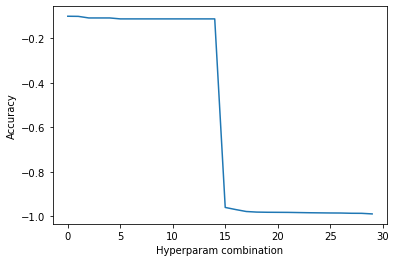

In [42]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

### Evaluate the model

In [43]:
# load best model

model_hyp = load_model(path_best_model)

In [44]:
# make predictions in test set

result = model_hyp.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 32s 59ms/step - loss: 0.0567 - accuracy: 0.9862


In [45]:
# print evaluation metrics

for name, value in zip(model_hyp.metrics_names, result):
    print(name, value)

loss 0.05668258294463158
accuracy 0.9861904978752136


In [46]:
# Predict the values from the validation dataset
y_pred = model_hyp.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 [==============================] - 31s 59ms/step


array([[403,   0,   1,   2,   0,   0,   1,   0,   1,   0],
       [  0, 463,   1,   0,   0,   0,   1,   6,   0,   0],
       [  0,   1, 413,   0,   1,   0,   0,   4,   1,   0],
       [  0,   0,   0, 500,   0,   2,   0,   4,   0,   0],
       [  0,   0,   1,   0, 391,   0,   0,   1,   0,   4],
       [  0,   0,   0,   2,   0, 328,   2,   0,   4,   3],
       [  1,   0,   0,   0,   1,   0, 400,   0,   0,   0],
       [  0,   1,   2,   0,   0,   0,   0, 434,   1,   0],
       [  0,   0,   1,   0,   1,   1,   0,   1, 398,   1],
       [  0,   0,   0,   0,   0,   1,   0,   2,   1, 412]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

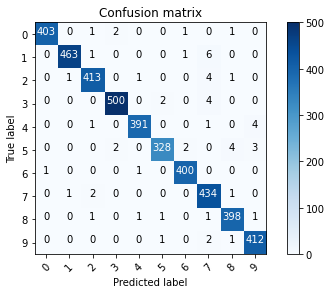

In [47]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Make Predictions on Test data 

In [48]:
# Import the test data 
test_df = pd.read_csv('test.csv')
test_df.head()  

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preprocessing the data 

In [49]:
test_df = test_df / 255
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
test_df = test_df.values.reshape(-1,28,28,1)


In [51]:
y_pred = model_hyp.predict(test_df)


875/875 [==============================] - 83s 68ms/step


In [52]:
y_pred_ = np.argmax(y_pred, axis = 1)


In [53]:
sub = pd.DataFrame(y_pred_,columns=['Label']).reset_index()

In [54]:
sub['index'] = np.arange(1, len(sub) + 1)


In [55]:
sub

,index,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [56]:
sub.rename(columns = {'index':'ImageId'}, inplace = True)

In [57]:
sub.to_csv('Submission_hyp2.csv',index=False)